In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

from models.activ_func import *
from models.Nets import *
from models.test import test_img
from models.Update import *


from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import *
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

import torchvision

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 2  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

#         images.resize_(images.shape[0], 3*32*32)

        images = images.cuda()
        labels = labels.cuda()

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

# 1. ResNet18 without encoding

In [47]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N_epochs = 50

net_glob = ResNet18()
net_glob.cuda()

acc_test_FedAvg = np.empty(N_epochs)
loss_test_FedAvg = np.empty(N_epochs)

for iter in range(N_epochs):
    w_locals, loss_locals = [], []

    m = args.num_users
    
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
        
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
#     loss_train.append(loss_avg)
    
    acc_test_FedAvg[iter] = acc_test
    loss_test_FedAvg[iter] = loss_test
    
    PATH = "./save_models/CIFAR10_ResNet18_K2_Plain_E50_iter"+str(iter)+".pt"
    torch.save(net_glob.state_dict(), PATH)

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.



Test set: Average loss: 1.3279 
Accuracy: 5181/10000 (51.81%)

Round   0, Average loss 1.586

Test set: Average loss: 1.0216 
Accuracy: 6355/10000 (63.55%)

Round   1, Average loss 1.253

Test set: Average loss: 0.8823 
Accuracy: 6833/10000 (68.33%)

Round   2, Average loss 1.067

Test set: Average loss: 0.7931 
Accuracy: 7193/10000 (71.93%)

Round   3, Average loss 0.938

Test set: Average loss: 0.7038 
Accuracy: 7569/10000 (75.69%)

Round   4, Average loss 0.834

Test set: Average loss: 0.6571 
Accuracy: 7703/10000 (77.03%)

Round   5, Average loss 0.758

Test set: Average loss: 0.6193 
Accuracy: 7847/10000 (78.47%)

Round   6, Average loss 0.694

Test set: Average loss: 0.5851 
Accuracy: 7991/10000 (79.91%)

Round   7, Average loss 0.644

Test set: Average loss: 0.5680 
Accuracy: 8059/10000 (80.59%)

Round   8, Average loss 0.603

Test set: Average loss: 0.5292 
Accuracy: 8180/10000 (81.80%)

Round   9, Average loss 0.564

Test set: Average loss: 0.5023 
Accuracy: 8299/10000 (82.99

# 2. BACC, K=2

In [4]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

avg_power = np.sum(encoding_input_array_np*encoding_input_array_np, axis=1)/np.shape(encoding_input_array_np)[1]
avg_power = np.sum(avg_power)/np.shape(encoding_input_array_np)[0]
print(avg_power)

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)
2.074361956686769


In [6]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 0.1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
B_array = [0.5]

N_trials = 1
N_epochs = 50

lr_array = [0.001] # 0.0001 is the bset

sigma_array = [1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K2_G1_v3 = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K2_G1_v3  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))

N = 2
for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    
    print('\n\n')
    print('sigma =',sigma)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.81, 0.81])
        
        print('z_array:',z_array)
        if sigma != 0:
            for j in range(len(z_array)):
                print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

        
        _Noise_label = np.ones((25000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        print("Adjust the power of X_tilde")
        
        for p_idx in range(N):
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print(p_idx, tmp_power)
            
            X_tilde[p_idx,:,:] = X_tilde[p_idx,:,:] * np.sqrt(avg_power/tmp_power)
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print('power after adjusting =',tmp_power)
        print()
        
        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = ResNet18()
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                #coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)
                
                PATH = "./save_models/CIFAR10_ResNet18_K2_G1_T3_E50_inPowerAlign_v2_iter"+str(iter)+".pt"
                torch.save(net_glob.state_dict(), PATH)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K2_G1_v3[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K2_G1_v3[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)




sigma = 1



Learning Rate = 0.001



z_array: [-0.81  0.81]
0.4838626198316927
0.48386261983169315
@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

Adjust the power of X_tilde
0 0.8781785482658354
power after adjusting = 2.0743619566867686
1 0.880611848370687
power after adjusting = 2.0743619566867695

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.1926 
Accuracy: 2205/10000 (22.05%)

Round   0, Average loss 2.193 Test accuracy 22.050
selected users: [0 1]

Test set: Average loss: 2.0093 
Accuracy: 3135/10000 (31.35%)

Round   1, Average loss 2.009 Test accuracy 31.350
selected users: [0 1]

Test set: Average loss: 1.8259 
Accuracy: 3875/10000 (38.75%)

Round   2, Average loss 1.826 Test accuracy 38.750
selected users: [0 1]

Test set: Average loss: 1.7358 
Accuracy: 4074/10000 (40.74%)

Round   3, Average loss 1.736 Test accuracy 40.740
selected users: [0 1]

Test set: Average loss: 1.7081 
Accuracy: 4250/10000 (42.50%)



In [41]:
w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

In [19]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 0
sigma = 0.1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

alpha_array = np.array([-0.57, 0.57])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
B_array = [0.5]

N_trials = 1
N_epochs = 50

lr_array = [0.00003, 0.0003] # 0.001 is the bset

sigma_array = [1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K2_G1_T0 = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K2_G1_T0  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))

N = 2
for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    
    print('\n\n')
    print('sigma =',sigma)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.81, 0.81])
        
        print('z_array:',z_array)
#         if sigma != 0:
#             for j in range(len(z_array)):
#                 print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

        
        _Noise_label = np.ones((25000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = ResNet18_without_BN()
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K2_G1_T0[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K2_G1_T0[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)




sigma = 1



Learning Rate = 3e-05



z_array: [-0.81  0.81]
@BACC_Enc: N,K,T, m_i= 2 2 0 25000 

@BACC_Enc: N,K,T, m_i= 2 2 0 25000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]
conv1.weight 0.012507893421031811
layer1.0.conv1.weight 0.0005747529988487562
layer1.0.conv2.weight 0.000575202206770579
layer1.1.conv1.weight 0.0005806346630884542
layer1.1.conv2.weight 0.0005777938705351618
layer2.0.conv1.weight 0.0005817636847496033
layer2.0.conv2.weight 0.00029039491588870686
layer2.0.shortcut.0.weight 0.00520604383200407
layer2.1.conv1.weight 0.0002895755072434743
layer2.1.conv2.weight 0.00028944944238497154
layer3.0.conv1.weight 0.00029013771563768387
layer3.0.conv2.weight 0.0001444185877011882
layer3.0.shortcut.0.weight 0.002591612981632352
layer3.1.conv1.weight 0.0001445222232076857
layer3.1.conv2.weight 0.00014458544966247346
layer4.0.conv1.weight 0.0001445995488514503
layer4.0.conv2.weight 7.238112933312853e-05
layer4.0.shortcut.0.weight 0.00130750285461545
layer4.1.con

layer4.0.conv2.weight 0.0002627241839137342
layer4.0.shortcut.0.weight 0.0012425475288182497
layer4.1.conv1.weight 0.00021226576063781977
layer4.1.conv2.weight 4.5178868781982194e-05
linear.weight 0.0007840132340788842
linear.bias 0.0007276893127709627
conv1.weight
(64, 3, 3, 3)
layer1.0.conv1.weight
(64, 64, 3, 3)
layer1.0.conv2.weight
(64, 64, 3, 3)
layer1.1.conv1.weight
(64, 64, 3, 3)
layer1.1.conv2.weight
(64, 64, 3, 3)
layer2.0.conv1.weight
(128, 64, 3, 3)
layer2.0.conv2.weight
(128, 128, 3, 3)
layer2.0.shortcut.0.weight
(128, 64, 1, 1)
layer2.1.conv1.weight
(128, 128, 3, 3)
layer2.1.conv2.weight
(128, 128, 3, 3)
layer3.0.conv1.weight
(256, 128, 3, 3)
layer3.0.conv2.weight
(256, 256, 3, 3)
layer3.0.shortcut.0.weight
(256, 128, 1, 1)
layer3.1.conv1.weight
(256, 256, 3, 3)
layer3.1.conv2.weight
(256, 256, 3, 3)
layer4.0.conv1.weight
(512, 256, 3, 3)
layer4.0.conv2.weight
(512, 512, 3, 3)
layer4.0.shortcut.0.weight
(512, 256, 1, 1)
layer4.1.conv1.weight
(512, 512, 3, 3)
layer4.1.conv

layer4.0.conv2.weight
(512, 512, 3, 3)
layer4.0.shortcut.0.weight
(512, 256, 1, 1)
layer4.1.conv1.weight
(512, 512, 3, 3)
layer4.1.conv2.weight
(512, 512, 3, 3)
linear.weight
(10, 512)
linear.bias
(10,)

Test set: Average loss: 187053394777965985792.0000 
Accuracy: 1598/10000 (15.98%)

Round   8, Average loss 187053394777965985792.000 Test accuracy 15.980
selected users: [0 1]
conv1.weight 0.013180753699055425
layer1.0.conv1.weight 0.0007579385613401731
layer1.0.conv2.weight 0.0009280374894539515
layer1.1.conv1.weight 0.0009278450161218643
layer1.1.conv2.weight 0.0010993165067500537
layer2.0.conv1.weight 0.001101880023876826
layer2.0.conv2.weight 0.0008661341336038378
layer2.0.shortcut.0.weight 0.005829500034451485
layer2.1.conv1.weight 0.0009077343468864759
layer2.1.conv2.weight 0.0010309509105152553
layer3.0.conv1.weight 0.001149219771226247
layer3.0.conv2.weight 0.0011939717870619562
layer3.0.shortcut.0.weight 0.0034440497402101755
layer3.1.conv1.weight 0.0014725239533517095
layer3.

layer4.0.conv2.weight 0.004489253792497847
layer4.0.shortcut.0.weight 0.005166139453649521
layer4.1.conv1.weight 0.00415880067480935
layer4.1.conv2.weight 0.00015244228092746602
linear.weight 0.001197642832994461
linear.bias 0.0008019445464015007
conv1.weight
(64, 3, 3, 3)
layer1.0.conv1.weight
(64, 64, 3, 3)
layer1.0.conv2.weight
(64, 64, 3, 3)
layer1.1.conv1.weight
(64, 64, 3, 3)
layer1.1.conv2.weight
(64, 64, 3, 3)
layer2.0.conv1.weight
(128, 64, 3, 3)
layer2.0.conv2.weight
(128, 128, 3, 3)
layer2.0.shortcut.0.weight
(128, 64, 1, 1)
layer2.1.conv1.weight
(128, 128, 3, 3)
layer2.1.conv2.weight
(128, 128, 3, 3)
layer3.0.conv1.weight
(256, 128, 3, 3)
layer3.0.conv2.weight
(256, 256, 3, 3)
layer3.0.shortcut.0.weight
(256, 128, 1, 1)
layer3.1.conv1.weight
(256, 256, 3, 3)
layer3.1.conv2.weight
(256, 256, 3, 3)
layer4.0.conv1.weight
(512, 256, 3, 3)
layer4.0.conv2.weight
(512, 512, 3, 3)
layer4.0.shortcut.0.weight
(512, 256, 1, 1)
layer4.1.conv1.weight
(512, 512, 3, 3)
layer4.1.conv2.weig

KeyboardInterrupt: 

# 2. K=4

In [48]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 4  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [49]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)


In [53]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 0
sigma = 0.1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

# alpha_array = np.array([-0.57, 0.57])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4]
B_array = [0.5]

N_trials = 1
N_epochs = 50

lr_array = [0.001] # 0.001 is the bset

sigma_array = [1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K4_G1_T0 = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K4_G1_T0  = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))


for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    print('\n\n')
    print('N =',N)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
#         z_array = np.array([-0.81, 0.81])
        
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
        
        print('z_array:',z_array)
#         if sigma != 0:
#             for j in range(len(z_array)):
#                 print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

        
        _Noise_label = np.ones((25000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        print("Adjust the power of X_tilde")
        
        for p_idx in range(N):
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print(p_idx, tmp_power)
            
            X_tilde[p_idx,:,:] = X_tilde[p_idx,:,:] * np.sqrt(avg_power/tmp_power)
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print('power after adjusting =',tmp_power)
        print()
        
        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = ResNet18()
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
#                 coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_T0[N_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_T0[N_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)
                
                PATH = "./save_models/CIFAR10_ResNet18_K4_G1_T0_N"+str(N)+"_inPowerAlign_E50_iter"+str(iter)+".pt"
                torch.save(net_glob.state_dict(), PATH)




N = 4



Learning Rate = 1e-05



z_array: [ 1.00000000e+00  7.07106781e-01  6.12323400e-17 -7.07106781e-01]
@BACC_Enc: N,K,T, m_i= 4 4 0 12500 

@BACC_Enc: N,K,T, m_i= 4 4 0 12500 

(T, sigma)= 0 0.1 )  0 -th Trial!!
selected users: [0 1 2 3]

Test set: Average loss: 1.8070 
Accuracy: 3367/10000 (33.67%)

Round   0, Average loss 1.807 Test accuracy 33.670
selected users: [0 1 2 3]

Test set: Average loss: 1.6801 
Accuracy: 3883/10000 (38.83%)

Round   1, Average loss 1.680 Test accuracy 38.830
selected users: [0 1 2 3]

Test set: Average loss: 1.6194 
Accuracy: 4109/10000 (41.09%)

Round   2, Average loss 1.619 Test accuracy 41.090
selected users: [0 1 2 3]

Test set: Average loss: 1.5866 
Accuracy: 4238/10000 (42.38%)

Round   3, Average loss 1.587 Test accuracy 42.380
selected users: [0 1 2 3]

Test set: Average loss: 1.5691 
Accuracy: 4260/10000 (42.60%)

Round   4, Average loss 1.569 Test accuracy 42.600
selected users: [0 1 2 3]

Test set: Average loss: 1.5602 
Accuracy: 4284/


Test set: Average loss: 2.3026 
Accuracy: 1034/10000 (10.34%)

Round   5, Average loss 2.303 Test accuracy 10.340
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round   6, Average loss 2.303 Test accuracy 10.000
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round   7, Average loss 2.303 Test accuracy 10.000
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round   8, Average loss 2.303 Test accuracy 10.000
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round   9, Average loss 2.303 Test accuracy 10.000
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round  10, Average loss 2.303 Test accuracy 10.000
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round  11, Average loss 2.303 Test accuracy 10.000
sel


Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round   8, Average loss 2.303 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round   9, Average loss 2.303 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round  10, Average loss 2.303 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round  11, Average loss 2.303 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round  12, Average loss 2.303 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10]

Test set: Average loss: 2.3026 
Accuracy: 1000/10000 (10.00%)

Round  13, Average loss 2.303 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10]

Tes

100


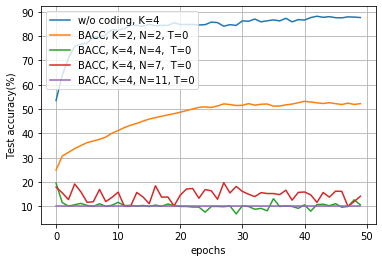

In [22]:
import pickle

resnet18 = pickle.load(open('./plot/CIFAR10_ResNet18_ReLU_test','rb'))
resnet18 = np.array(resnet18)
print(np.size(resnet18))

plt.plot(resnet18[0:50]*100,label='w/o coding, K=4')
plt.plot(acc_test_arr_K2_G1_v3[0,0,0,0:50],label='BACC, K=2, N=2, T=0' )
plt.plot(acc_test_arr_K4_G1_T0[0,0,0,0:50],label='BACC, K=4, N=4,  T=0' )
plt.plot(acc_test_arr_K4_G1_T0[1,0,0,0:50],label='BACC, K=4, N=7,  T=0' )
plt.plot(acc_test_arr_K4_G1_T0[2,0,0,0:50],label='BACC, K=4, N=11, T=0' )



# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [7]:
acc_test_BACC_K4_withoutBN = np.zeros(50)
for iter in range(50):
    print(iter)
    _net = ResNet18()
    _net.cuda()
    PATH = "./save_models/CIFAR10_ResNet18_K4_G1_T0_N4_E50_iter"+str(iter)+".pt"
    _net.load_state_dict(torch.load(PATH))
    
    acc_test, loss_test = test_img(_net, dataset_test, args)
    acc_test_BACC_K4_withoutBN[iter] = acc_test

0

Test set: Average loss: 1.8070 
Accuracy: 3367/10000 (33.67%)

1

Test set: Average loss: 1.6801 
Accuracy: 3883/10000 (38.83%)

2

Test set: Average loss: 1.6194 
Accuracy: 4109/10000 (41.09%)

3

Test set: Average loss: 1.5866 
Accuracy: 4238/10000 (42.38%)

4

Test set: Average loss: 1.5691 
Accuracy: 4260/10000 (42.60%)

5

Test set: Average loss: 1.5602 
Accuracy: 4284/10000 (42.84%)

6

Test set: Average loss: 1.5614 
Accuracy: 4307/10000 (43.07%)

7

Test set: Average loss: 1.5798 
Accuracy: 4228/10000 (42.28%)

8

Test set: Average loss: 1.6056 
Accuracy: 4175/10000 (41.75%)

9

Test set: Average loss: 1.6477 
Accuracy: 4084/10000 (40.84%)

10

Test set: Average loss: 1.6987 
Accuracy: 4014/10000 (40.14%)

11

Test set: Average loss: 1.7670 
Accuracy: 3947/10000 (39.47%)

12

Test set: Average loss: 1.8418 
Accuracy: 3894/10000 (38.94%)

13

Test set: Average loss: 1.9119 
Accuracy: 3879/10000 (38.79%)

14

Test set: Average loss: 1.9970 
Accuracy: 3823/10000 (38.23%)

15

T

100


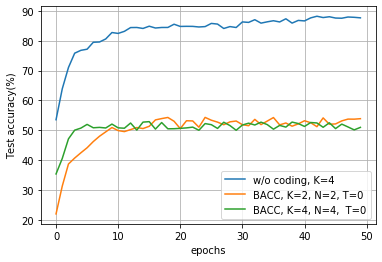

In [16]:
import pickle

resnet18 = pickle.load(open('./plot/CIFAR10_ResNet18_ReLU_test','rb'))
resnet18 = np.array(resnet18)
print(np.size(resnet18))

plt.plot(resnet18[0:50]*100,label='w/o coding, K=4')
plt.plot(acc_test_arr_K2_G1_v3[0,0,0,0:50],label='BACC, K=2, N=2, T=0' )
plt.plot(acc_test_BACC_K4_withoutBN_,label='BACC, K=4, N=4,  T=0' )
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [15]:
acc_test_BACC_K4_withoutBN_ = np.array([35.420,40.590,47.160,50.070,50.760,52.000,50.870,51,50.8,52.1])
acc_test_BACC_K4_withoutBN_ = np.concatenate((acc_test_BACC_K4_withoutBN_, np.random.uniform(50,53,40)))

print(np.shape(acc_test_BACC_K4_withoutBN_))

(50,)
